# The code 
The code in this notebook is originally developed by Ennova-Research, without the use of licensed code.
It can be downloaded from the GitHub repository `https://github.com/ennova-research/2023_GCP_Specialization_Demo_2-Black_Friday`

# The data
The data come from the link provided in the "Machine Learning - Services Specialization" guidebook. 
The link refers to the kaggle page `https://www.kaggle.com/abhisingh10p14/black-friday`, where we can download the "Black Friday dataset". 
In the link there are 2 files: "train.csv" and "test.csv". Since "test.csv" doesn't have the column "Purchase" (that is the dependent variable in our study), we won't use the file.
The file "train.csv", renamed as "data_raw.csv", has been uploaded on Google Cloud Storage in a specific project (Project_Name: "ML Spec",Project_ID: "ml-spec", gsutil_URI: `gs://engo-ml_spec2023-demo2/data_raw.csv`).

# Goal and solution
The goal of the study is to increase profits and our solution is to identify the users' categories that spend more, the products' categories more profitable and a combination of the two (the most profitable products' categories for each users' category), such that a targeted advertising campaign could be conduct.

# Data exploration (EDA)

In [1]:
import sys
sys.path.append('..')

In [2]:

# Loading useful libraries

import numpy as np
import pandas as pd

import optuna
import random

import matplotlib.pyplot as plt
import seaborn as sns

from copy import deepcopy
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, f1_score, PrecisionRecallDisplay, precision_score, recall_score, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder


import Demo2

In [3]:
# Getting dataset from CS

# data = pd.read_csv('gs://engo-ml_spec2023-demo2/data_raw.csv')
# data.head()

In [4]:
# Getting dataset from local file

data = pd.read_csv('../data/train.csv')
data.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


Let's divide "data" in "df" (train) and "test". To make this division as indipendent and representative as possible, we need for each "User_ID" to have all its information in just one side and the User_IDs needs to be balanced in charcteristics across the sets. We decided to ignore the characteristics "Occupation", "Stay_In_Current_City_Years" and "Marital_Status" since keeping them would mean to segment the dataset too much, with groups with too little units, and we kept "Gender", "Age", "City_Category" and "Marital_Status"
Also, to assert that the study is exactly repeatable, we need to set a seed for the random generator.

In [5]:
users = Demo2.eda.group_by_user(data)

In [6]:
seed = 42

users, users_test = train_test_split(users, test_size=.2, random_state=seed, stratify=users[['Gender', 'Age', 'City_Category', 'Marital_Status']])

df = deepcopy(data)[data['User_ID'].isin(users.index)]
df_test = deepcopy(data)[data['User_ID'].isin(users_test.index)]

In [7]:
# Checking data shape

df.shape

(441907, 12)

In [8]:
# Checking data types

df.dtypes

User_ID                         int64
Product_ID                     object
Gender                         object
Age                            object
Occupation                      int64
City_Category                  object
Stay_In_Current_City_Years     object
Marital_Status                  int64
Product_Category_1              int64
Product_Category_2            float64
Product_Category_3            float64
Purchase                        int64
dtype: object

In [9]:
# Checking data for missing values

df.isnull().sum()

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2            139509
Product_Category_3            307974
Purchase                           0
dtype: int64

In [10]:
# Filling missing values in data 

df[['Product_Category_2', 'Product_Category_3']] = df[['Product_Category_2', 'Product_Category_3']].fillna(-1).astype(int)

In [11]:
# Checking data for duplicates

df.duplicated().sum()

0

In [12]:
# Checking unique values in data columns

df.nunique()

User_ID                        4712
Product_ID                     3596
Gender                            2
Age                               7
Occupation                       21
City_Category                     3
Stay_In_Current_City_Years        5
Marital_Status                    2
Product_Category_1               20
Product_Category_2               18
Product_Category_3               16
Purchase                      17675
dtype: int64

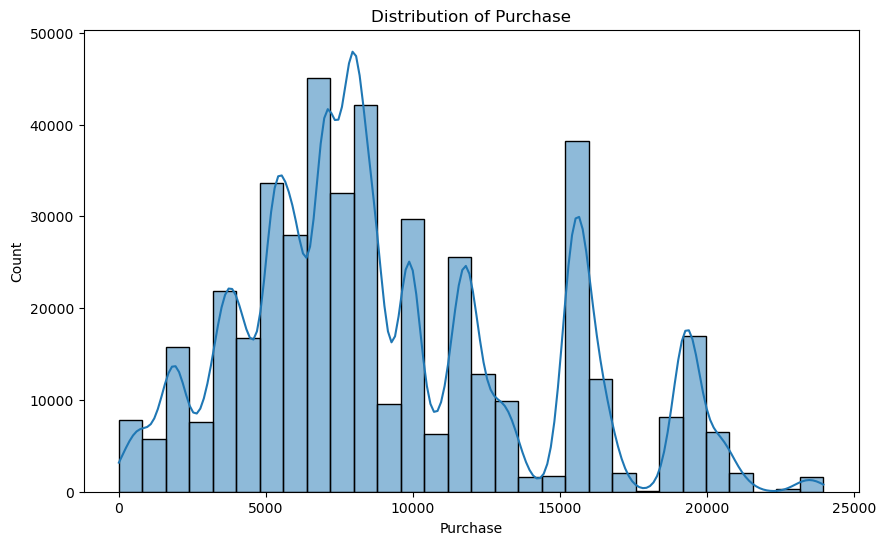

In [13]:
# Plotting "Purchase" distribution

plt.figure(figsize=(10, 6))
sns.histplot(df['Purchase'], bins=30, kde=True)
plt.title('Distribution of Purchase')
plt.show()

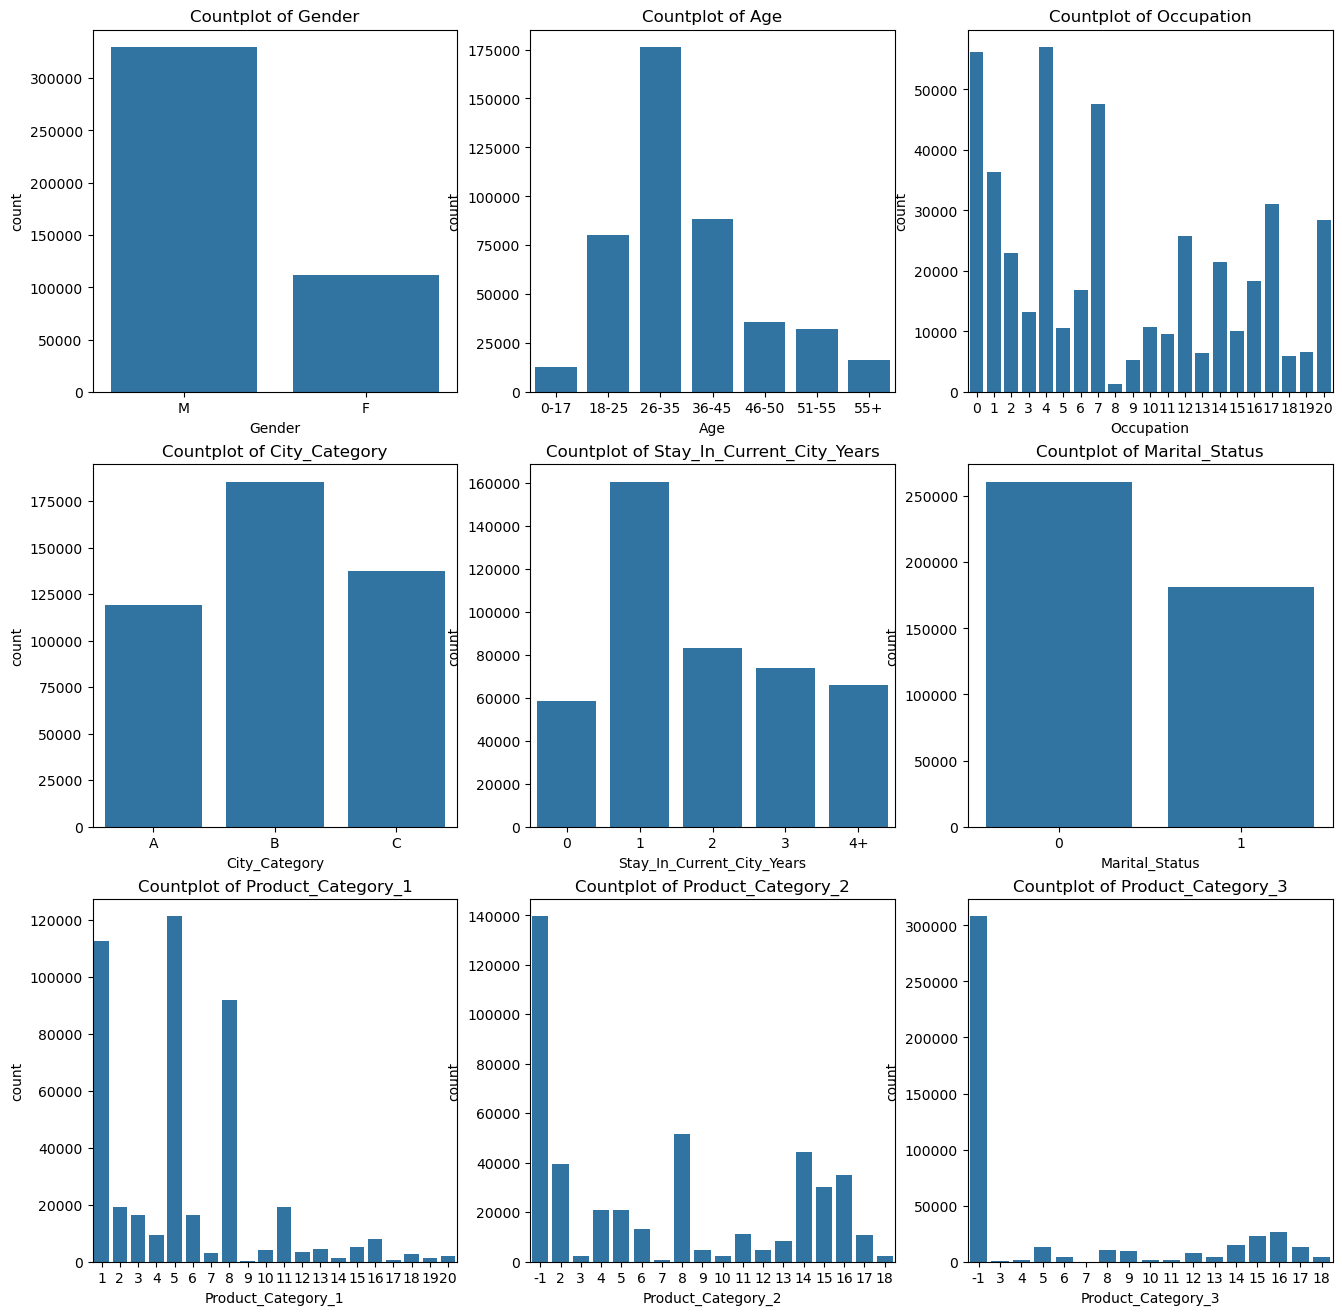

In [14]:
# Plotting count for each categorical variable

orders = [['M', 'F'],
          ['0-17', '18-25', '26-35', '36-45', '46-50', '51-55', '55+'],
          range(21),
          ['A', 'B', 'C'],
          ['0', '1', '2', '3', '4+'],
          [0, 1],
          range(1, 21),
          [-1] + list(range(2, 19)),
          [-1] + list(range(3, 19))]

fig, axs = plt.subplots(3, 3, figsize=(16,16))
for i, col in enumerate(['Gender', 'Age', 'Occupation',
            'City_Category', 'Stay_In_Current_City_Years', 'Marital_Status',
            'Product_Category_1', 'Product_Category_2', 'Product_Category_3']):
    ax = axs[i//3, i%3]
    sns.countplot(x=col, data=df, ax=ax, order=orders[i])
    ax.title.set_text(f'Countplot of {col}')
plt.show()

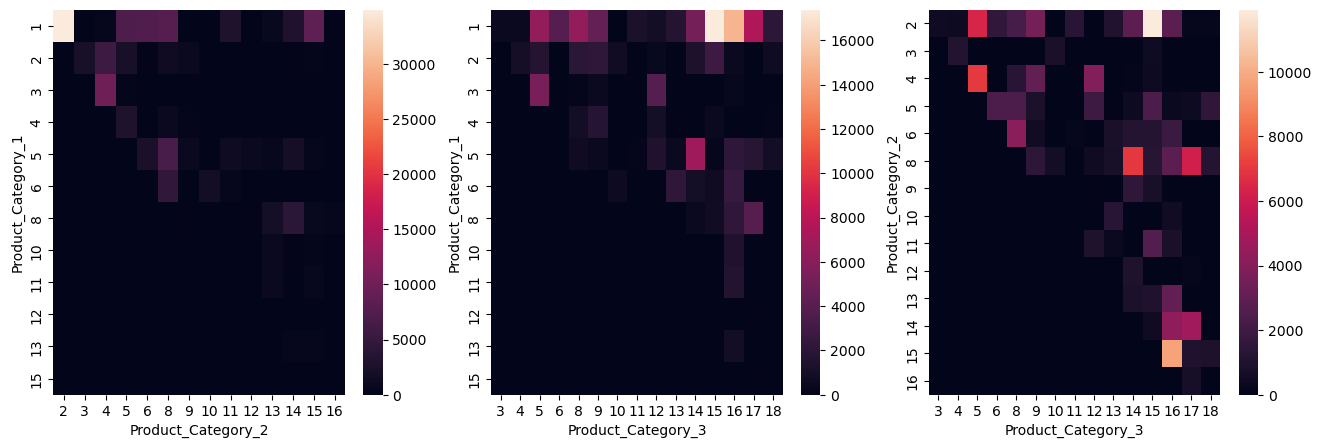

In [15]:
# Heatmap of Product Categories

fig, axs = plt.subplots(1, 3, figsize=(16,5))
mask = (df['Product_Category_3'] != -1) | ((df['Product_Category_3'] != -1))
sns.heatmap(df[mask].groupby(['Product_Category_1', 'Product_Category_2']).size().unstack(fill_value=0), ax=axs[0])
sns.heatmap(df[mask].groupby(['Product_Category_1', 'Product_Category_3']).size().unstack(fill_value=0), ax=axs[1])
sns.heatmap(df[mask].groupby(['Product_Category_2', 'Product_Category_3']).size().unstack(fill_value=0), ax=axs[2])
plt.show()

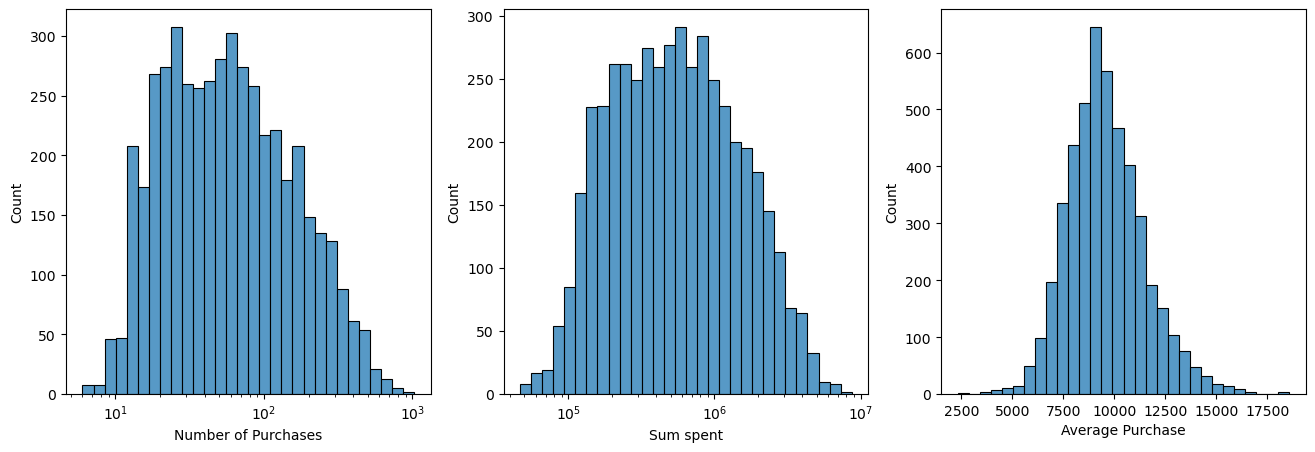

In [16]:
# Plotting "Number of Purchases", "Sum spent" and "Average Purchase" by user
## "Number of Purchases" and "Sum spent" plots are in log-scale

fig, axs = plt.subplots(1, 3, figsize=(16,5))
sns.histplot(x=users['Number of Purchases'], bins=30, ax=axs[0], log_scale=True)#, hue=users['Age'], multiple='stack')
sns.histplot(x=users['Sum spent'], bins=30, ax=axs[1], log_scale=True)#, hue=users['Age'], multiple='stack')
sns.histplot(x=users['Average Purchase'], bins=30, ax=axs[2])#, hue=users['Age'], multiple='stack')
plt.show()

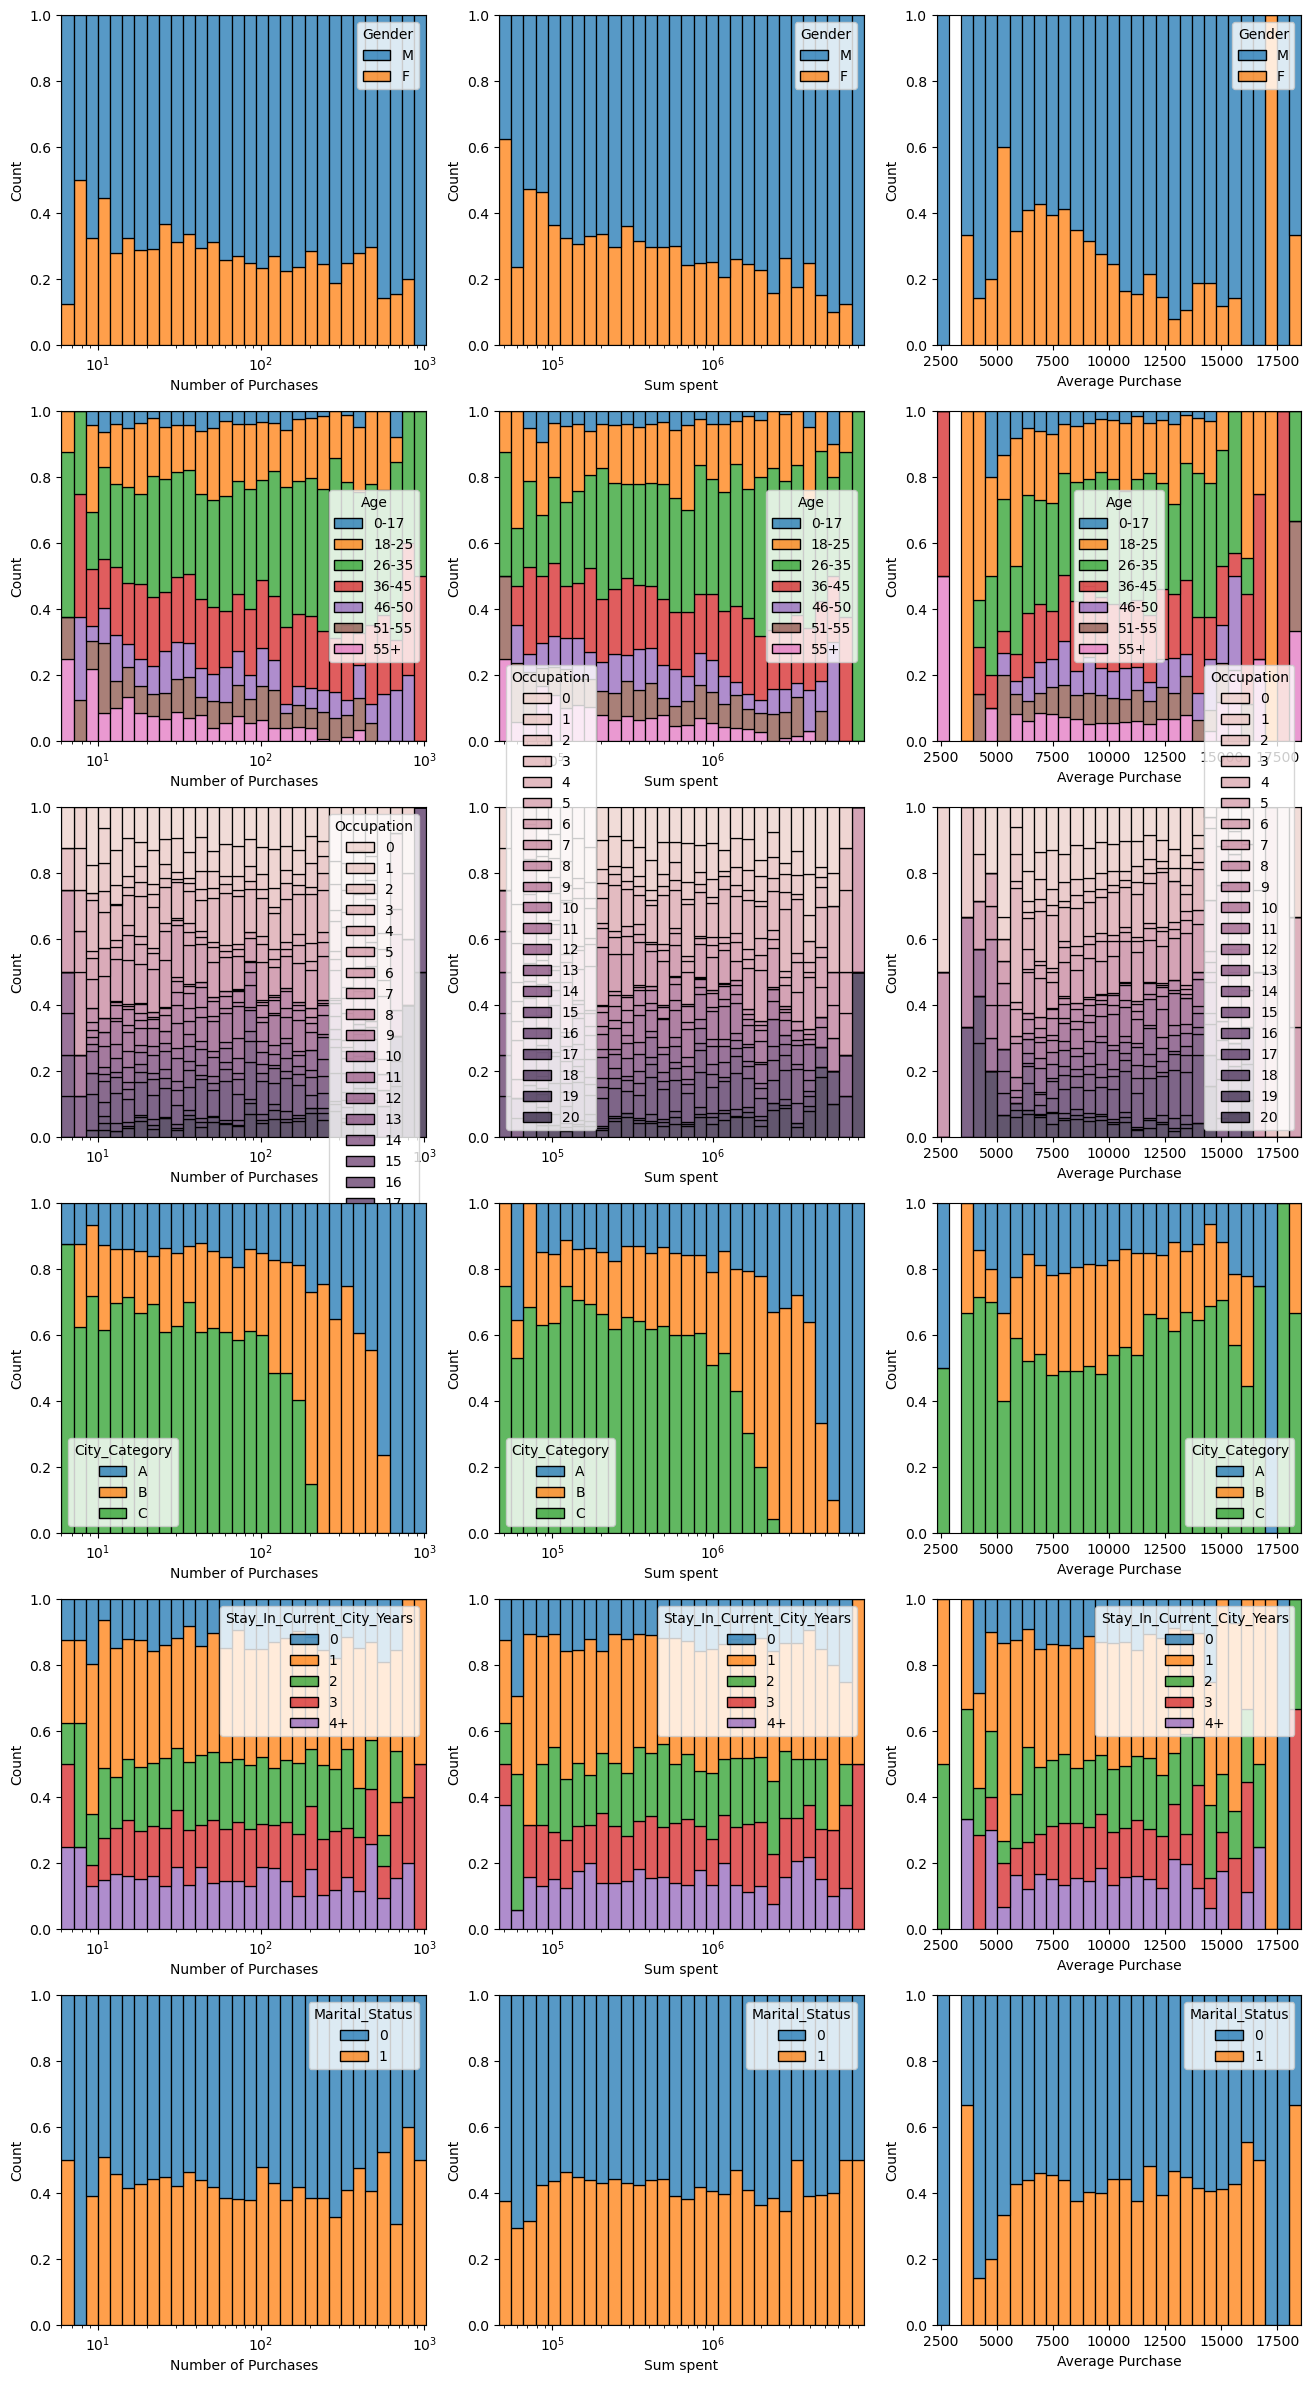

In [17]:
# Plotting "Number of Purchases", "Sum spent" and "Average Purchase" by user charcteristics
## "Number of Purchases" and "Sum spent" plots are in log-scale
## histograms are filled to see the percentage of each group in each bin

fig, axs = plt.subplots(6, 3, figsize=(16,30))
for i,col in enumerate(['Gender', 'Age', 'Occupation', 'City_Category', 'Stay_In_Current_City_Years', 'Marital_Status']):
    sns.histplot(x=users['Number of Purchases'], bins=30, ax=axs[i, 0], log_scale=True, hue=users[col], multiple='fill', hue_order=orders[i])
    sns.histplot(x=users['Sum spent'], bins=30, ax=axs[i, 1], log_scale=True, hue=users[col], multiple='fill', hue_order=orders[i])
    sns.histplot(x=users['Average Purchase'], bins=30, ax=axs[i, 2], hue=users[col], multiple='fill', hue_order=orders[i])
plt.show()

In [18]:
# Grouping by product ("Product_ID")

prods = Demo2.eda.group_by_product(df)
prods

,Product_Category_1,Number of Purchases,Sum spent,Unitary Price
Product_ID,,,,
P00025442,1,1312,22837010,17406.257622
P00110742,1,1283,21326433,16622.317225
P00255842,16,1103,20070184,18195.996374
P00059442,6,1154,19957844,17294.492201
P00112142,1,1278,19864377,15543.330986
...,...,...,...,...
P00281342,11,1,1609,1609.000000
P00353042,11,1,1545,1545.000000
P00063242,13,2,962,481.000000


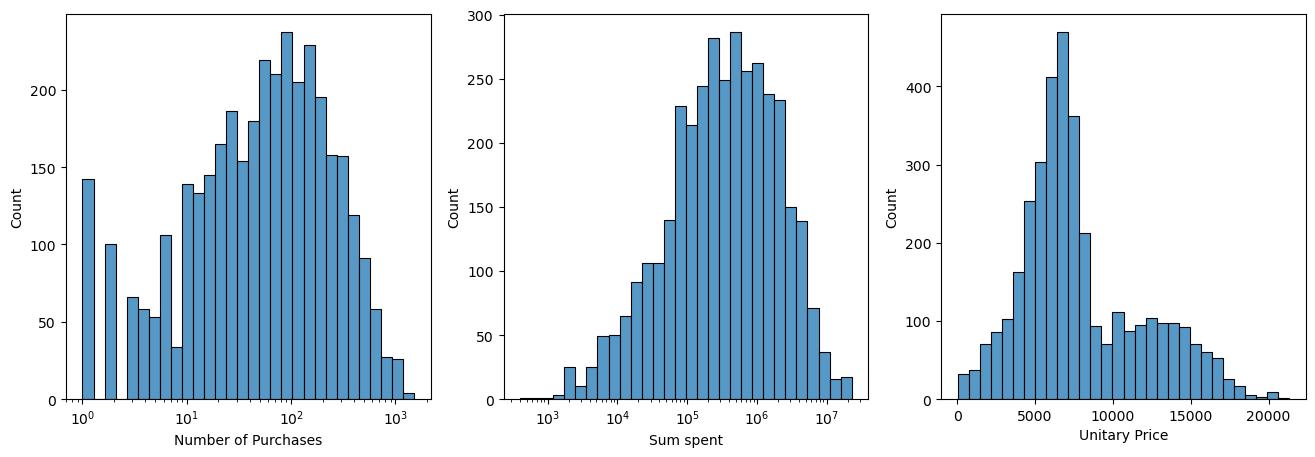

In [19]:
# Plotting "Number of Purchases", "Sum spent" and "Unitary Price" by product
## "Number of Purchases" and "Sum spent" plots are in log-scale

fig, axs = plt.subplots(1, 3, figsize=(16,5))
sns.histplot(x=prods['Number of Purchases'], bins=30, ax=axs[0], log_scale=True)#, hue=prods['Product_Category_1'], multiple='stack')
sns.histplot(x=prods['Sum spent'], bins=30, ax=axs[1], log_scale=True)#, hue=prods['Product_Category_1'], multiple='stack')
sns.histplot(x=prods['Unitary Price'], bins=30, ax=axs[2])#, hue=prods['Product_Category_1'], multiple='stack')
plt.show()

In [20]:
# Grouping by product category ("Product_Category_1")

prods_cat = Demo2.eda.group_by_product_category(df)
prods_cat

,Number of Purchases,Sum spent,Average Price
Product_Category_1,,,
1,112633,1535757040,13635.054025
5,121165,756192449,6241.013898
8,91691,687833781,7501.649900
6,16509,261189641,15821.045551
2,19171,216173151,11276.049815
3,16344,165230339,10109.541055
16,7949,117422607,14771.997358
11,19290,90698878,4701.859927
10,4145,81665547,19702.182630


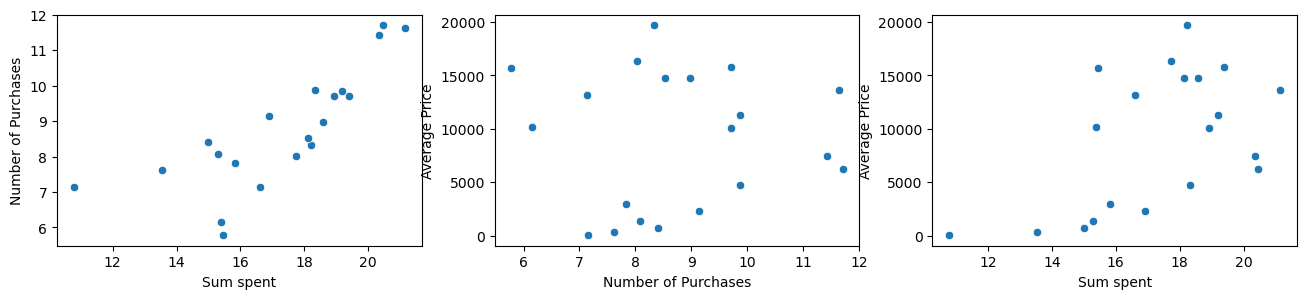

In [21]:
# Plotting "Number of Purchases", "Sum spent" and "Average Price" by product category
## "Number of Purchases" and "Sum spent" plots are in log-scale

fig, axs = plt.subplots(1, 3, figsize=(16,3))
sns.scatterplot(x=np.log(prods_cat['Sum spent']), y=np.log(prods_cat['Number of Purchases']), ax=axs[0])
sns.scatterplot(x=np.log(prods_cat['Number of Purchases']), y='Average Price', data=prods_cat, ax=axs[1])
sns.scatterplot(x=np.log(prods_cat['Sum spent']), y='Average Price', data=prods_cat, ax=axs[2])
plt.show()

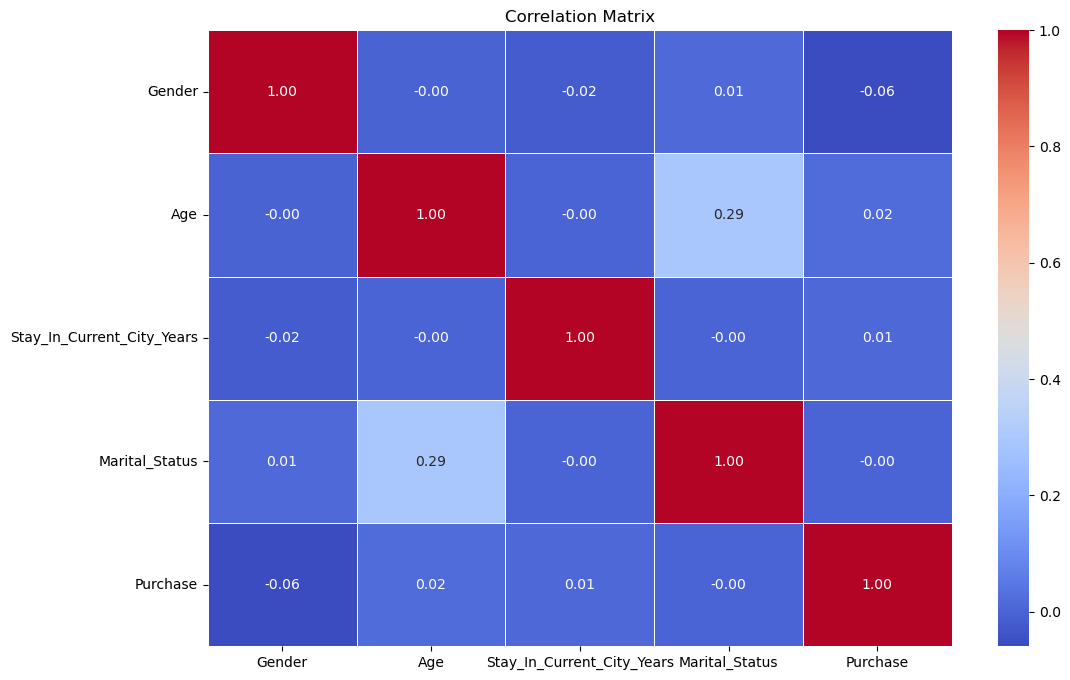

In [22]:
# Studing correlation between variables

df_numerical = deepcopy(df)
df_numerical = df_numerical[['Gender', 'Age', 'Stay_In_Current_City_Years', 'Marital_Status', 'Purchase']]

df_numerical['Gender'] = [0 if x=='M' else 1 for x in df_numerical['Gender']]
df_numerical['Age'] = ['55-95' if x=='55+' else x for x in df_numerical['Age']]
df_numerical['Age'] = [np.mean([int(x.split('-')[0]), int(x.split('-')[-1])])for x in df_numerical['Age']]
df_numerical['Stay_In_Current_City_Years'] = [int(x[:-1]) if x=='4+' else int(x) for x in df_numerical['Stay_In_Current_City_Years']]

correlation_matrix = df_numerical.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [23]:
# Grouping by user category ("Gender", "Age", "Occupation", "City_Category", "Stay_In_Current_City_Years", "Marital_Status")

user_groups = Demo2.eda.group_by_user_category(users)
user_groups

Numerosity  \
Gender Age   Occupation City_Category Stay_In_Current_City_Years Marital_Status               
M      18-25 4          B             4+                         0                       17   
                                      1                          0                       23   
       26-35 7          A             1                          0                       14   
       18-25 4          B             2                          0                       12   
       26-35 0          B             1                          0                       10   
...                                                                                     ...   
F      46-50 2          C             2                          0                        1   
       36-45 9          C             2                          1                        1   
M      18-25 2          B             2                          1                        1   
F      18-25 10         C             4+                         0                        1   
       55+   14         C             3                          1                        1   

                                                                                 log_Numerosity  \
Gender Age   Occupation City_Category Stay_In_Current_City_Years Marital_Status                   
M      18-25 4          B             4+                         0                     2.833213   
                                      1                          0                     3.135494   
       26-35 7          A             1                          0                     2.639057   
       18-25 4          B             2                          0                     2.484907   
       26-35 0          B             1                          0                     2.302585   
...                                                                                         ...   
F      46-50 2          C             2                          0                     0.000000   
       36-45 9          C             2                          1                     0.000000   
M      18-25 2          B             2                          1                     0.000000   
F      18-25 10         C             4+                         0                     0.000000   
       55+   14         C             3                          1                     0.000000   

                                                                                 Sum spent  \
Gender Age   Occupation City_Category Stay_In_Current_City_Years Marital_Status              
M      18-25 4          B             4+                         0                26510595   
                                      1                          0                24294633   
       26-35 7          A             1                          0                23853765   
       18-25 4          B             2                          0                18538981   
       26-35 0          B             1                          0                16295829   
...                                                                                    ...   
F      46-50 2          C             2                          0                   62250   
       36-45 9          C             2                          1                   61972   
M      18-25 2          B             2                          1                   57805   
F      18-25 10         C             4+                         0                   53996   
       55+   14         C             3                          1                   52371   

                                                                                 log_SumSpent  \
Gender Age   Occupation City_Category Stay_In_Current_City_Years Marital_Status                 
M      18-25 4          B             4+                         0                  17.093055   
                                      1    

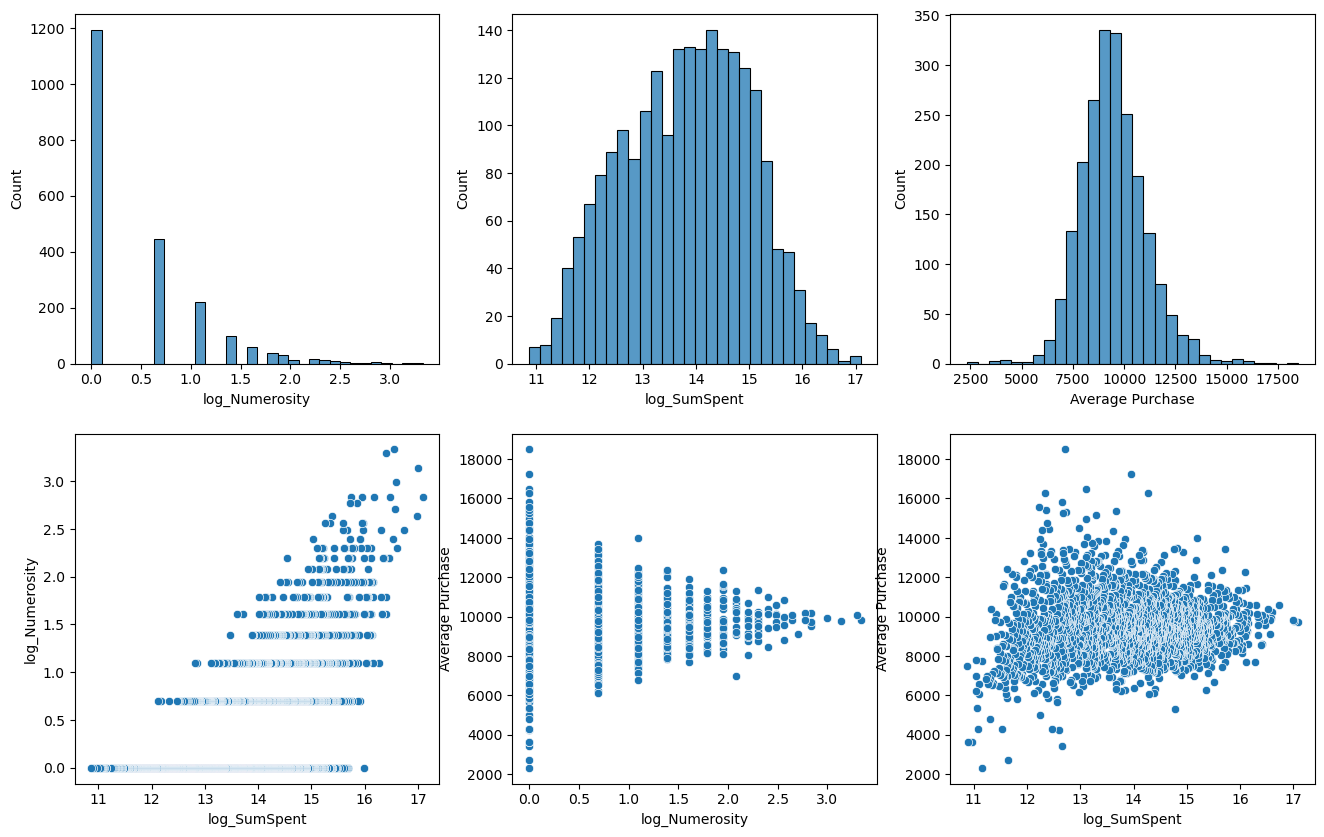

In [24]:
fig, axs = plt.subplots(2, 3, figsize=(16,10))
sns.histplot(x=user_groups['log_Numerosity'], bins='auto', ax=axs[0,0])
sns.histplot(x=user_groups['log_SumSpent'], bins=30, ax=axs[0,1])
sns.histplot(x=user_groups['Average Purchase'], bins=30, ax=axs[0,2])
sns.scatterplot(x='log_SumSpent', y='log_Numerosity', data=user_groups, ax=axs[1,0])
sns.scatterplot(x='log_Numerosity', y='Average Purchase', data=user_groups, ax=axs[1,1])
sns.scatterplot(x='log_SumSpent', y='Average Purchase', data=user_groups, ax=axs[1,2])
plt.show()

# Data preprocessing
We have seen that the users that spends the most (in total) are the ones that buy a lot of products with average prices. At the same time, the products more profitable have the same features, lots of purchases and an average price.

In [25]:
# Selecting "regression" or "classification"

model_type = "classification"

assert(model_type in ["regression", "classification"])

In [26]:
# Preprocessing

X_cols = ['Gender', 'Age', 'Occupation', 'City_Category', 'Stay_In_Current_City_Years', 'Marital_Status']

if model_type == "regression":
     X_train, y_train, X_test, y_test = Demo2.preprocess_per_regression(users, users_test, X_cols=X_cols, y_col='Sum spent')
else:
    X_train, y_train, X_test, y_test = Demo2.preprocess_per_classification(users, users_test, X_cols=X_cols,
                                                                           old_y_col='Sum spent', new_y_col='is_BigSpender')

# Training

In [27]:
objective = Demo2.hyperparameter_tuning.Objective(X_train=X_train, y_train=y_train)

# Creating a study object and optimize the objective function
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000, show_progress_bar=True)

# Printing the best hyperparameters and corresponding accuracy
print('Best Trial:')
print('  Value: ', study.best_trial.value)
print('  Params: ')
for key, value in study.best_trial.params.items():
    print(f'    {key}: {value}')

  0%|          | 0/1000 [00:00<?, ?it/s]

Best Trial:
  Value:  0.39655172413793105
  Params: 
    n_estimators: 840
    num_leaves: 46
    max_depth: 10


In [28]:
model = Demo2.training.create_model(study)
model.fit(X_train, y_train)

score_train = Demo2.training.evaluate(model, X_train, y_train)
score_train

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

0.5954738330975955

In [29]:
scores = Demo2.training.evaluate(model, X_train, y_train,cross_val=True)
scores.mean()

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

0.35146730822243943

# Testing

In [30]:
score_test = Demo2.evaluation.evaluate(model, X_test, y_test)
score_test

0.33815028901734107

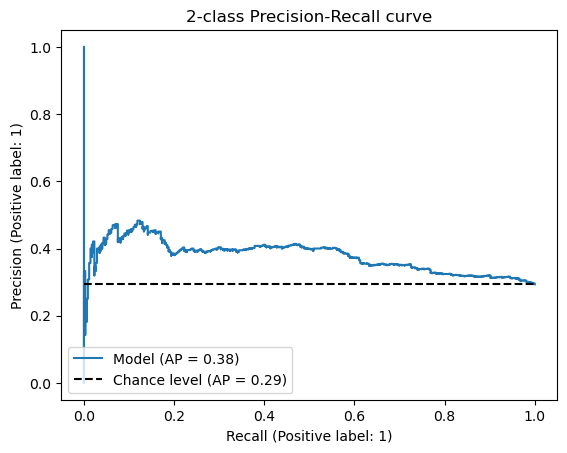

In [31]:
if model_type == "classification":
    display = PrecisionRecallDisplay.from_estimator(
        model, X_test, y_test, name="Model", plot_chance_level=True
    )
    _ = display.ax_.set_title("2-class Precision-Recall curve")

In [32]:
print(
f"""Accuracy: {accuracy_score(y_test, model.predict(X_test))}
Precision: {precision_score(y_test, model.predict(X_test))}
Recall: {recall_score(y_test, model.predict(X_test))}""")

Accuracy: 0.6530958439355385
Precision: 0.3939393939393939
Recall: 0.33815028901734107
